In [1]:
import rasterio
import numpy as np

# Data Source - https://github.com/globalmaps/gm_ve_v1
forests_file = rasterio.open('data/forests.tif')
forests = forests_file.read()

print(np.amin(forests))
print(np.amax(forests))
print(len(np.unique(forests)))

0
254
102


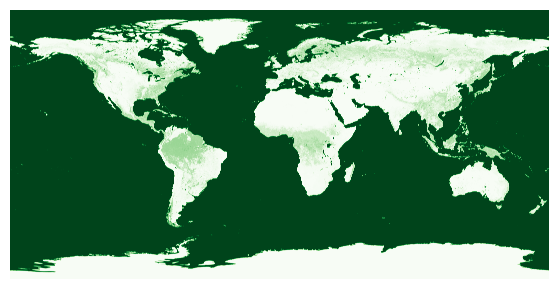

In [2]:
from rasterio.plot import show
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
fig.set_size_inches(7, 3.5)
show(forests, ax=ax, cmap='Greens')

ax.axis('off')
plt.show()

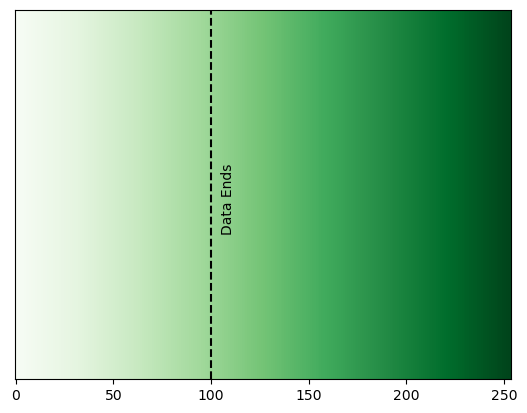

In [3]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import cm

purples = cm.get_cmap('Greens', 254)
newcolors = purples(np.linspace(0, 1, 254))
newcmp_forests = ListedColormap(newcolors)
bounds = np.arange(102)
norm_forests = BoundaryNorm(bounds, newcmp_forests.N)


gradient = np.linspace(0, 1, 254)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots()
ax.imshow(gradient, aspect='auto', cmap=newcmp_forests)
ax.get_yaxis().set_visible(False)
ax.axvline(100, ls="--", c='black', )
plt.text(105, 0.7, "Data Ends", rotation=90)
plt.show()

In [4]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import cm

greens = cm.get_cmap('Greens', 101)
newcolors = greens(np.linspace(0, 1, 101))
background_colour = np.array([0.0, 0.0, 0.0, 0.0])
newcolors[:1, :] = background_colour
newcmp_forests = ListedColormap(newcolors)

bounds = np.arange(102)
norm_forests = BoundaryNorm(bounds, newcmp_forests.N)

In [5]:
forests[forests == 254] = 0

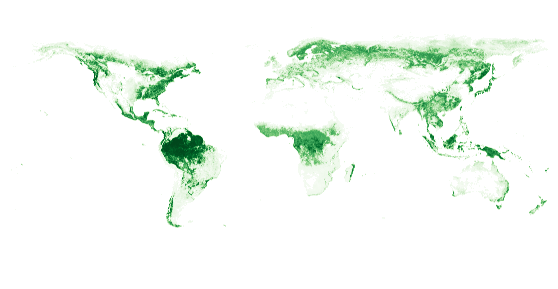

In [6]:
from rasterio.plot import show
fig, ax = plt.subplots()
fig.set_size_inches(7, 3.5)
show(forests, ax=ax, cmap=newcmp_forests, norm=norm_forests)
ax.axis('off')
plt.show()

In [7]:
import rioxarray as rxr
from rasterio.crs import CRS

forests_file = rxr.open_rasterio('data/forests.tif', masked=True).squeeze()
print("Original projection: ", forests_file.rio.crs)
crs_rob = CRS.from_string('+proj=robin')
forests = forests_file.rio.reproject(crs_rob)
print("New projection: ", forests.rio.crs)
forests = forests.to_numpy()

Original projection:  EPSG:4326
New projection:  PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Robinson"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


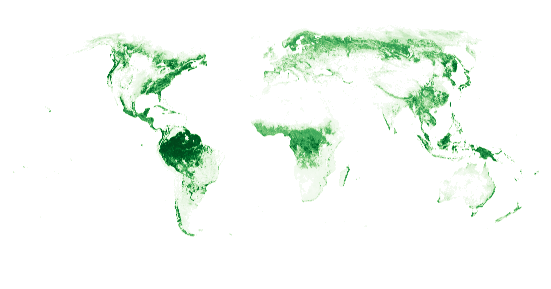

In [8]:
forests[forests > 100] = 0.0

fig, ax = plt.subplots()
fig.set_size_inches(7, 3.5)

show(forests, ax=ax, cmap=newcmp_forests, norm=norm_forests)
ax.axis('off')
plt.show()

In [9]:
import geopandas as gpd
import pandas as pd

# Data source - https://github.com/nvkelso/natural-earth-vector/blob/master/10m_cultural/ne_10m_admin_0_countries.shp
df = gpd.read_file('data/ne_10m_admin_0_countries.shp')

samerica = df.loc[df['ADMIN'] == 'Colombia']

In [11]:
import rasterio
from rasterio import mask as msk 
from shapely.geometry import mapping

forests_file = rasterio.open('data/forests.tif')

clipped_array, clipped_transform = rasterio.mask.mask(forests_file, [mapping(geom) for geom in (samerica.geometry.tolist())], 
                                                      crop=True, nodata=0)

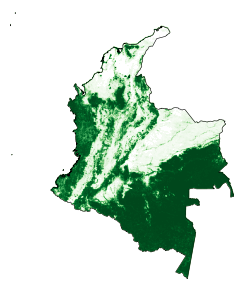

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 3.5)

show(clipped_array[0], ax=ax, transform=clipped_transform, cmap=newcmp_forests, norm=norm_forests)
samerica.boundary.plot(ax=ax, edgecolor='black',  lw=0.4)

ax.axis('off')

plt.show()

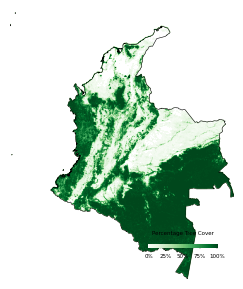

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 3.5)

show(clipped_array[0], ax=ax, transform=clipped_transform, cmap=newcmp_forests, norm=norm_forests)
samerica.boundary.plot(ax=ax, edgecolor='black',  lw=0.4)

fig = ax.get_figure()
cax = fig.add_axes([0.55, 0.2, 0.1, 0.01])
sm = plt.cm.ScalarMappable(cmap=newcmp_forests, norm=norm_forests)
sm._A = []
cb = fig.colorbar(sm, cax=cax, orientation="horizontal", pad=0, format='%.3g',
                  ticks=[1, 25, 50, 75, 100], drawedges=False)
cb.ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=4, width=0.2, length=0.75, color='black')
cbytick_obj = plt.getp(cb.ax, 'xticklabels' ) #Set y tick label color
plt.setp(cbytick_obj, color='black')
cb.ax.set_xlabel('Percentage Tree Cover', fontsize=4, color='black', labelpad=-20)

ax.axis('off')
plt.show()

In [14]:
from rasterio.io import MemoryFile

memfile = MemoryFile()
dataset = memfile.open(driver='GTiff', height=clipped_array.shape[1], width=clipped_array.shape[2], 
                       count=1, crs=forests_file.crs, 
                       transform=clipped_transform, dtype=clipped_array.dtype)
dataset.write(clipped_array[0], 1)

In [15]:
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject

# Define the destination CRS - Mercator projection
dst_crs = 'EPSG:3395'

# Calculate the transform and dimensions for the new projection
transform, width, height = calculate_default_transform(dataset.crs, dst_crs, dataset.width, dataset.height, *dataset.bounds)

# Create a destination numpy array
dst_array = np.empty((height, width), dtype=clipped_array.dtype)

# Perform the reprojection
reproject(
    source=rasterio.band(dataset, 1),
    destination=dst_array,
    src_transform=dataset.transform,
    src_crs=dataset.crs,
    dst_transform=transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest
)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 Affine(928.1071383025912, 0.0, -9097585.385080248,
        0.0, -928.1071383025912, 1516427.1529010898))

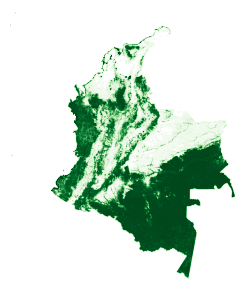

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 3.5)

show(dst_array, ax=ax, transform=transform, cmap=newcmp_forests, norm=norm_forests)

ax.axis('off')
plt.show()


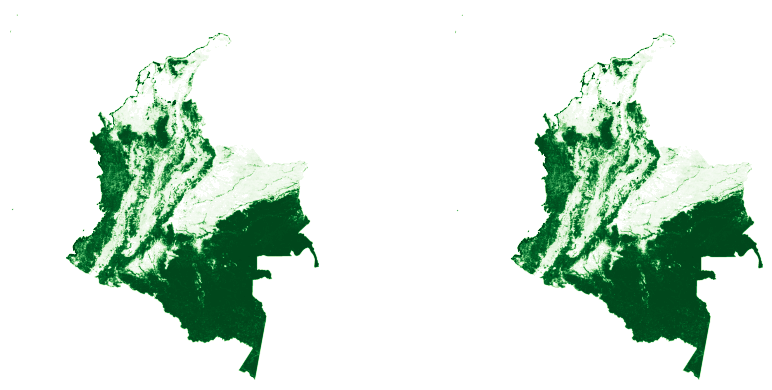

In [17]:
# Plot raster
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

show(clipped_array[0], ax=ax1, transform=clipped_transform, cmap=newcmp_forests, norm=norm_forests)

ax1.axis('off')

show(dst_array, ax=ax2, transform=transform, cmap=newcmp_forests, norm=norm_forests)

ax2.axis('off')

plt.tight_layout()
plt.show()

In [18]:
rows, cols = clipped_array[0].shape
col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))

# Calculate the real-world coordinates
xs, ys = rasterio.transform.xy(clipped_transform, row_indices.flatten(), col_indices.flatten())

# Create a DataFrame
df = pd.DataFrame({
    'X': xs,
    'Y': ys,
    'Value': clipped_array[0].flatten()
})

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y))

print(gdf)

                 X          Y  Value                    geometry
0       -81.720833  13.579167      0  POINT (-81.72083 13.57917)
1       -81.712500  13.579167      0  POINT (-81.71250 13.57917)
2       -81.704167  13.579167      0  POINT (-81.70417 13.57917)
3       -81.695833  13.579167      0  POINT (-81.69583 13.57917)
4       -81.687500  13.579167      0  POINT (-81.68750 13.57917)
...            ...        ...    ...                         ...
3811693 -66.912500  -4.237500      0  POINT (-66.91250 -4.23750)
3811694 -66.904167  -4.237500      0  POINT (-66.90417 -4.23750)
3811695 -66.895833  -4.237500      0  POINT (-66.89583 -4.23750)
3811696 -66.887500  -4.237500      0  POINT (-66.88750 -4.23750)
3811697 -66.879167  -4.237500      0  POINT (-66.87917 -4.23750)

[3811698 rows x 4 columns]


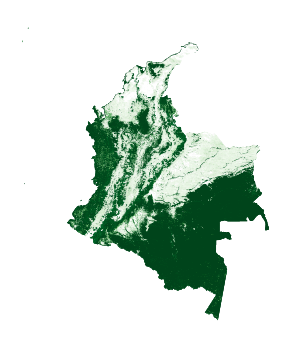

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(3.5, 7)

gdf.plot(ax=ax, column='Value', s=0.05, cmap=newcmp_forests, norm=norm_forests, edgecolors='none')
ax.axis('off')

plt.show()

In [20]:
import numpy as np
from osgeo import gdal, ogr
from osgeo import osr
from rasterio.transform import from_origin

gdal_transform = (clipped_transform.c, clipped_transform.a, clipped_transform.b,
                  clipped_transform.f, clipped_transform.d, clipped_transform.e)

# Create an in-memory raster
mem_drv_raster = gdal.GetDriverByName('MEM')
mem_raster = mem_drv_raster.Create('', clipped_array[0].shape[1], clipped_array[0].shape[0], 1, gdal.GDT_Int32)

# Set the geotransform
mem_raster.SetGeoTransform(gdal_transform)

# Write the data
mem_raster.GetRasterBand(1).WriteArray(clipped_array[0])

# Create an in-memory vector layer
mem_drv_vector = ogr.GetDriverByName('Memory')
mem_vector = mem_drv_vector.CreateDataSource('out')
mem_layer = mem_vector.CreateLayer('polygonized_raster', geom_type=ogr.wkbPolygon)

# Add a new field to store raster values
new_field = ogr.FieldDefn('DN', ogr.OFTInteger)
mem_layer.CreateField(new_field)

# Polygonize the raster to the in-memory vector layer
gdal.Polygonize(mem_raster.GetRasterBand(1), None, mem_layer, 0, [], callback=None)


0

In [21]:
from shapely.geometry import Polygon

geoms = []
vals = []

# Access the polygons
for feature in mem_layer:
    geom = feature.GetGeometryRef()
    
    # Extract the coordinates from the geometry
    ring = geom.GetGeometryRef(0)
    coordinates = []
    for i in range(ring.GetPointCount()):
        x, y = ring.GetX(i), ring.GetY(i)
        coordinates.append((x, y))
        
    geoms.append(Polygon(coordinates))
    vals.append(feature.GetField('DN'))

In [22]:
import pandas as pd

gdf = gpd.GeoDataFrame(pd.DataFrame({'vals': vals}), crs='EPSG:4326', geometry=geoms)

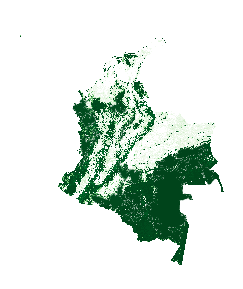

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(7, 3.5)
gdf.plot(ax=ax, column='vals', cmap=newcmp_forests, norm=norm_forests)
ax.axis('off')
plt.show()

In [24]:
from osgeo import ogr


# Generate contours directly in memory
mem_ds = ogr.GetDriverByName('Memory').CreateDataSource('out')
contour_lyr = mem_ds.CreateLayer('contour', geom_type=ogr.wkbLineString25D)

# Define fields of id and elev
field_def = ogr.FieldDefn("ID", ogr.OFTInteger)
contour_lyr.CreateField(field_def)
field_def = ogr.FieldDefn("elev", ogr.OFTReal)
contour_lyr.CreateField(field_def)

# Generate contours
gdal.ContourGenerate(mem_raster.GetRasterBand(1), 10, -11, [], 0, 0, contour_lyr, 0, 1)

gdal.Unlink('/vsimem/temp.vrt')
gdal.Unlink('/vsimem/mosaic.tif')

-1

In [25]:
from shapely.geometry import LineString

lines = [LineString(np.array(contour.GetGeometryRef().GetPoints())) for contour in contour_lyr]
elev = [contour.GetField('elev') for contour in contour_lyr]

In [26]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(pd.DataFrame({'elev': elev}), crs="EPSG:4326", geometry=lines)

print(gdf)

        elev                                           geometry
0       29.0  LINESTRING Z (-81.35772 13.37083 29.00000, -81...
1       39.0  LINESTRING Z (-81.35895 13.37083 39.00000, -81...
2       49.0  LINESTRING Z (-81.36017 13.37083 49.00000, -81...
3       59.0  LINESTRING Z (-81.36140 13.37083 59.00000, -81...
4       69.0  LINESTRING Z (-81.36989 13.35417 69.00000, -81...
...      ...                                                ...
179335  49.0  LINESTRING Z (-66.87500 1.22492 49.00000, -66....
179336  59.0  LINESTRING Z (-66.87500 1.22575 59.00000, -66....
179337  69.0  LINESTRING Z (-66.87500 1.22658 69.00000, -66....
179338  79.0  LINESTRING Z (-66.87500 1.22742 79.00000, -66....
179339  89.0  LINESTRING Z (-66.87500 1.22825 89.00000, -66....

[179340 rows x 2 columns]


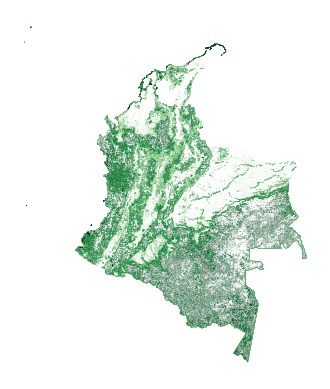

In [27]:
fig, ax = plt.subplots()
gdf.plot(ax=ax, lw=0.1, column='elev', cmap=newcmp_forests, norm=norm_forests)
ax.axis('off')
plt.show()